In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
# import MSTL cho việc phân tích chu kỳ
from statsmodels.tsa.seasonal import MSTL

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf, pacf

sns.set_context("talk")

---

In [5]:
# đọc dữ liệu
data = pd.read_csv("E:\\company\\oil_predict\\oil_price.csv", header=None)
data = data.dropna(how='all') # xóa các dòng toàn NaN
data = data.rename(columns={0: 'date'}) # đổi tên cột 0 thành Date
data = data.melt(id_vars=['date'], var_name='day', value_name='price')

dates = data["date"].unique() # tạo ra 1 thứ tự sắp xếp cho cột Date theo thứ tự xuất hiện trong mảng dates = data["Date"].unique()
data["date"] = pd.Categorical(data["date"], categories=dates, ordered=True) # sắp theo thứ tự ngày tăng dần và vẫn đảm bảo cột Date theo thứ tự xuất hiện trong mảng dates = data["Date"].unique()
data = data.sort_values(by=["date", "day"])

In [6]:
start_date = datetime(2010, 1, 4) # ngày bắt đầu
end_date = datetime(2023, 6, 16) # ngày kết thúc
date_range = pd.date_range(start=start_date, end=end_date) # tạo ra một danh sách các ngày từ ngày bắt đầu đến ngày kết thúc
business_days = date_range[date_range.weekday < 5] # lọc ra các ngày làm việc
data['date'] = business_days # thêm cột Date vào dữ liệu
data = data.drop(columns=['day'])  # loại bỏ cột Day
data = data.set_index('date') # đặt index là cột Date

---

In [7]:
# Tạo đối tượng biểu đồ
fig = go.Figure()

# Thêm dữ liệu và đường biểu đồ
fig.add_trace(go.Scatter(x=data.index, y=data["price"], mode='lines', name='Giá'))
fig.add_trace(go.Scatter(x=data.index, y=data["price"].diff(), mode="lines", name="Chênh lệch giá"))

# Đặt nhãn cho trục x và trục y
fig.update_xaxes(title_text='Ngày')
fig.update_yaxes(title_text='Giá')

# Đặt tiêu đề cho biểu đồ
fig.update_layout(title='Biểu đồ giá theo ngày từ 04/01/2010 - 16/06/2023')

# Hiển thị biểu đồ
fig.show()

---

In [8]:
# phân tích chu kỳ cho dữ liệu
mstl = MSTL(data['price'].interpolate(method="linear"), periods=(5)) # 5 là chu kỳ hàng tuần, 5*4 là chu kỳ hàng tháng, 5*4*3 là chu kỳ hàng quý
res = mstl.fit()

In [9]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Kiểm tra tính dừng của chuỗi thời gian
result = adfuller(res.resid)

# Trích xuất kết quả kiểm tra
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# In kết quả
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -19.64768377450041
p-value: 0.0
Critical Values:
   1%: -3.432230497161578
   5%: -2.8623708965439416
   10%: -2.567212300914916


In [10]:
df_deseasonal = data["price"] - res.seasonal

# thực hiện nội suy trên thành phần không có chu kỳ
df_deseasonal_imputed = df_deseasonal.interpolate(method="linear")
df_imputed = df_deseasonal_imputed  + res.seasonal

In [11]:
df = df_imputed.to_frame().rename(columns={0: 'price'})
df.isnull().sum()

price    0
dtype: int64

In [12]:
# Tạo đối tượng biểu đồ
fig = go.Figure()

# Thêm dữ liệu và đường biểu đồ
fig.add_trace(go.Scatter(x=df.index, y=df["price"], mode='lines', name='Giá'))
fig.add_trace(go.Scatter(x=df["price"][data["price"].isnull()].index, y=df["price"][data["price"].isnull()], mode='markers', name='Giá trị bị mất', marker=dict(size=4)))
# Đặt nhãn cho trục x và trục y
fig.update_xaxes(title_text='Ngày')
fig.update_yaxes(title_text='Giá')

# Đặt tiêu đề cho biểu đồ
fig.update_layout(title='Biểu đồ giá theo ngày từ 04/01/2010 - 16/06/2023')

# Hiển thị biểu đồ
fig.show()

---

In [13]:
res =  MSTL(df['price'].interpolate(method="linear"), periods=(5)).fit()

df['resid'] = res.resid

Q1 = df['resid'].quantile(0.25)
Q3 = df['resid'].quantile(0.75)
IQR = Q3 - Q1

alpha = 3.5
df['lower'] = Q1 - alpha * IQR
df['upper'] = Q3 + alpha * IQR
df['is_outlier'] = (df['resid'] < df['lower']) | (df['resid'] > df['upper'])

df.head()

,price,resid,lower,upper,is_outlier
date,,,,,
2010-01-04,81.51,-0.797366,-3.660718,3.674174,False
2010-01-05,81.77,-0.652922,-3.660718,3.674174,False
2010-01-06,83.18,0.574990,-3.660718,3.674174,False
2010-01-07,82.66,0.343087,-3.660718,3.674174,False
2010-01-08,82.75,1.168543,-3.660718,3.674174,False


In [14]:
df["is_outlier"].sum()

26

In [15]:
df['yhat'] = df["price"] - res.resid

# Tạo đối tượng biểu đồ
fig = go.Figure()

# Thêm dữ liệu và đường biểu đồ
fig.add_trace(go.Scatter(x=df.index, y=df["price"], mode='lines', name='Giá'))
fig.add_trace(go.Scatter(x=df.index, y=df["yhat"], mode='lines', line=dict(color="orange"), name='Giá dự đoán'))
fig.add_trace(go.Scatter(x=df.index, y=res.resid, mode='lines', name='Giá dự đoán'))
fig.add_trace(go.Scatter(x=df.index[df['is_outlier']], y=df['price'][df['is_outlier']], mode='markers', marker=dict(color='red'), name='Ngoại lệ'))
fig.add_trace(go.Scatter(x=df.index[df['is_outlier']], y=df['resid'][df['is_outlier']], mode='markers', marker=dict(color='red'), name='Ngoại lệ Resid'))
fig.add_trace(go.Scatter(x=df.index, y=df['upper'], mode='lines', line=dict(color='black', dash='dash'), name='Ngưỡng trên'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower'], mode='lines', line=dict(color='black', dash='dash'), name='Ngưỡng dưới'))

# Đặt nhãn cho trục x và trục y
fig.update_xaxes(title_text='Thời gian')
fig.update_yaxes(title_text='Giá')

# Đặt tiêu đề cho biểu đồ
fig.update_layout(title='Biểu đồ giá và các giá trị Outliers')

# Hiển thị biểu đồ
fig.show()

---

In [16]:
df_ = df.copy()

In [17]:
df.loc[df["is_outlier"], "price"] = np.NaN

In [18]:
# phân tích chu kỳ cho dữ liệu
mstl = MSTL(df['price'].interpolate(method="linear"), periods=(5)) # 5 là chu kỳ hàng tuần, 5*4 là chu kỳ hàng tháng, 5*4*3 là chu kỳ hàng quý
res = mstl.fit()

In [19]:
df_deseasonal = df["price"] - res.seasonal

# thực hiện nội suy trên thành phần không có chu kỳ
df_deseasonal_imputed = df_deseasonal.interpolate(method="linear")
df_imputed = df_deseasonal_imputed  + res.seasonal

In [20]:
df = df_imputed.to_frame().rename(columns={0: 'price'})
df.isnull().sum()

price    0
dtype: int64

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Tạo đối tượng khung chứa hai đồ thị
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Thêm dữ liệu và đồ thị cho đồ thị thứ nhất (Trước khi điều chỉnh ngoại lệ)
fig.add_trace(
    go.Scatter(x=df_.index, y=df_["price"], mode='lines', marker=dict(color='blue'), name='Trước khi điều chỉnh ngoại lệ'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_[df_["is_outlier"]].index, y=df_["price"][df_["is_outlier"]], mode='markers', marker=dict(color='red'), name='Ngoại lệ'),
    row=1, col=1
)

# Thêm dữ liệu và đồ thị cho đồ thị thứ hai (Sau khi điều chỉnh ngoại lệ)
fig.add_trace(
    go.Scatter(x=df.index, y=df["price"], mode='lines', marker=dict(color='green'), name='Sau khi điều chỉnh ngoại lệ'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df[df_["is_outlier"]].index, y=df["price"][df_["is_outlier"]], mode='markers', marker=dict(color='red'), name='Ngoại lệ sau khi điều chỉnh'),
    row=2, col=1
)

# Đặt nhãn cho trục x và trục y
fig.update_xaxes(title_text='Thời gian', row=2, col=1)
fig.update_yaxes(title_text='Giá', row=1, col=1)
fig.update_yaxes(title_text='Giá', row=2, col=1)

# Đặt tiêu đề cho biểu đồ
fig.update_layout(title='Biểu đồ giá trước và sau khi điều chỉnh ngoại lệ')

# Hiển thị biểu đồ
fig.show()


---

In [22]:
df['change'] = df['price'].pct_change() * 100

In [23]:
(81.77-81.51)/81.51

0.003189792663476762

In [24]:
df

,price,change
date,,
2010-01-04,81.51,NaN
2010-01-05,81.77,0.318979
2010-01-06,83.18,1.724349
2010-01-07,82.66,-0.625150
2010-01-08,82.75,0.108880
...,...,...
2023-06-12,67.12,-4.346587
2023-06-13,69.42,3.426698
2023-06-14,68.27,-1.656583


In [25]:
df.isnull().sum()

price     0
change    1
dtype: int64

<Axes: xlabel='date'>

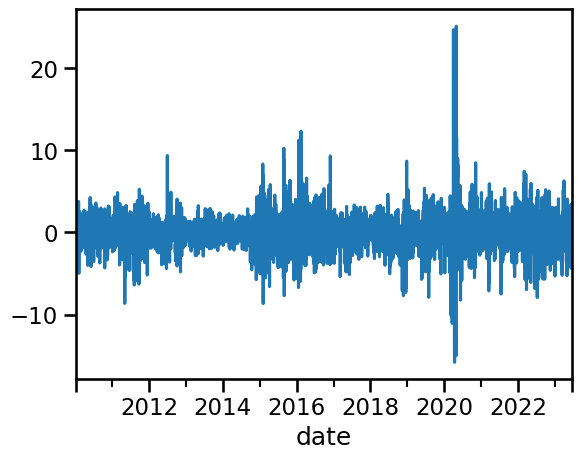

In [26]:
df["change"].plot()

<Axes: xlabel='date'>

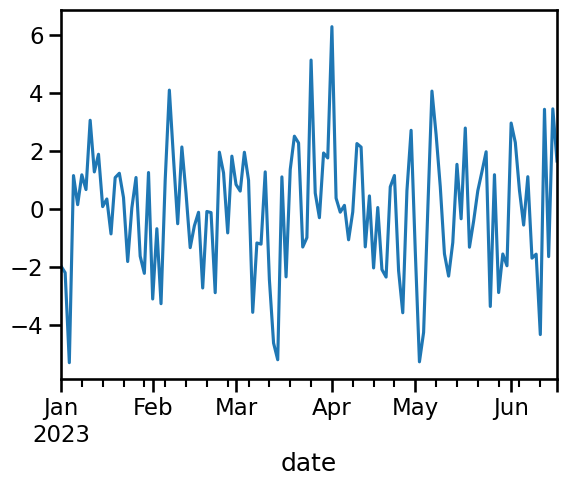

In [27]:
df.loc["2023-01-01":, "change"].plot()

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Kiểm tra tính dừng của chuỗi thời gian
result = adfuller(df["change"].dropna())

# Trích xuất kết quả kiểm tra
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# In kết quả
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -11.264476677993784
p-value: 1.5920377580251e-20
Critical Values:
   1%: -3.432226719361311
   5%: -2.862369227851233
   10%: -2.5672114125504795


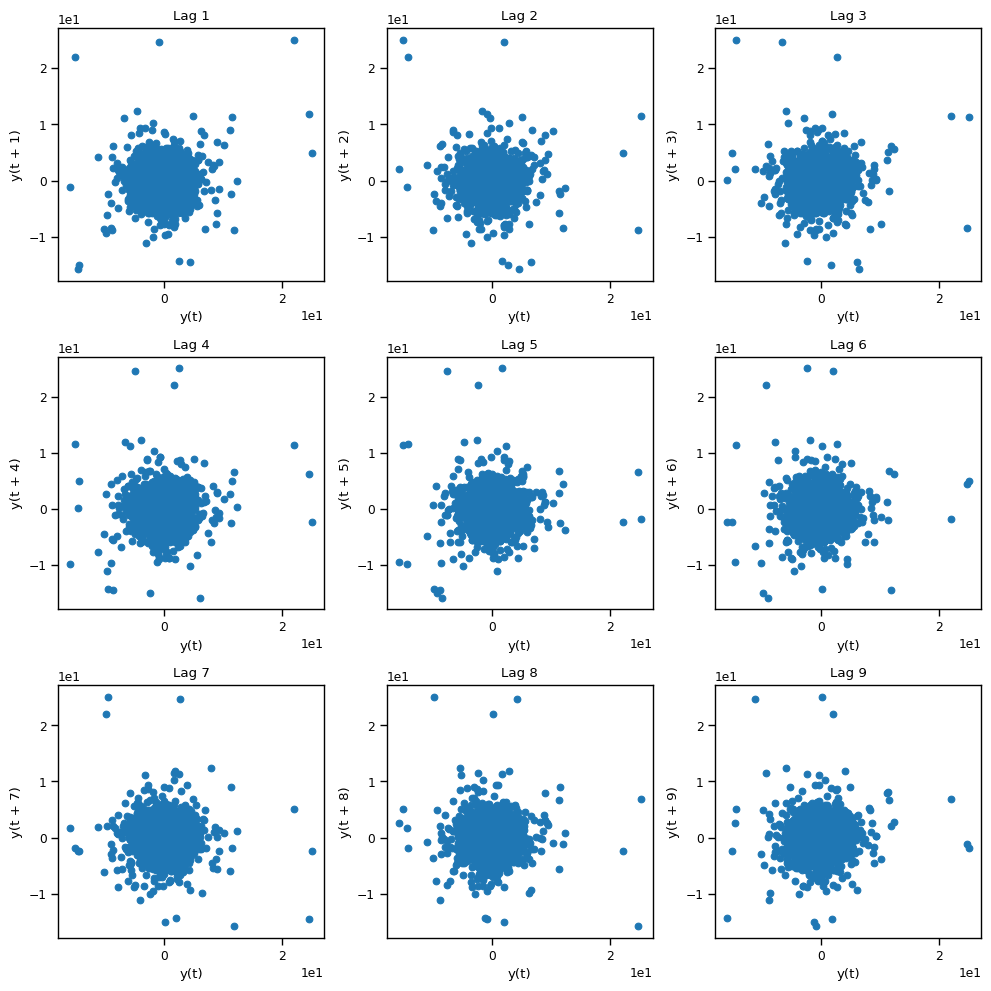

In [ ]:
# trực quan mối tương quan giữa lag và dữ liệu gốc
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
    for i, ax_ in enumerate(ax.flatten()):
        pd.plotting.lag_plot(df["change"], lag=i+1, ax=ax_)
        ax_.set_title("Lag {}".format(i+1))
        ax_.ticklabel_format(style='sci', scilimits=(0,0))
    plt.tight_layout()

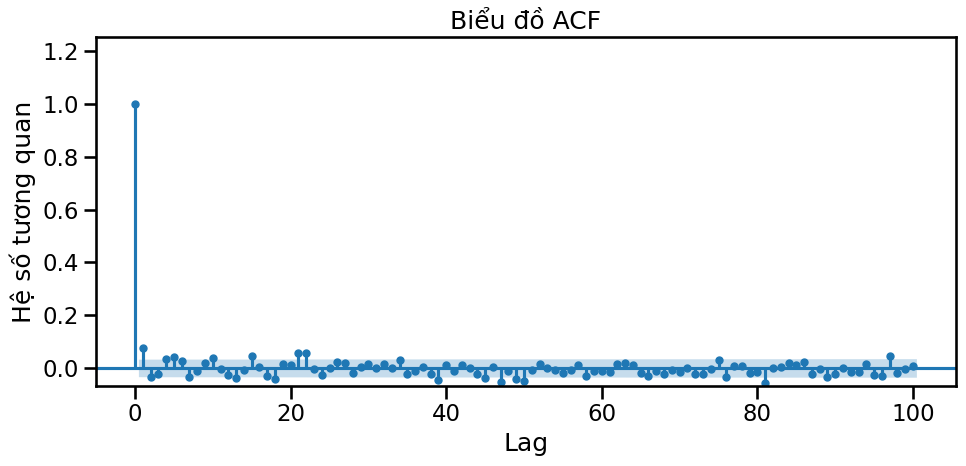

In [ ]:
# plot acf of detrended time series
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(x=df["change"].dropna(), lags=100, ax=ax, alpha=0.05, auto_ylims=True)
ax.set_title("Biểu đồ ACF")
ax.set_ylabel("Hệ số tương quan")
ax.set_xlabel("Lag")
plt.tight_layout()

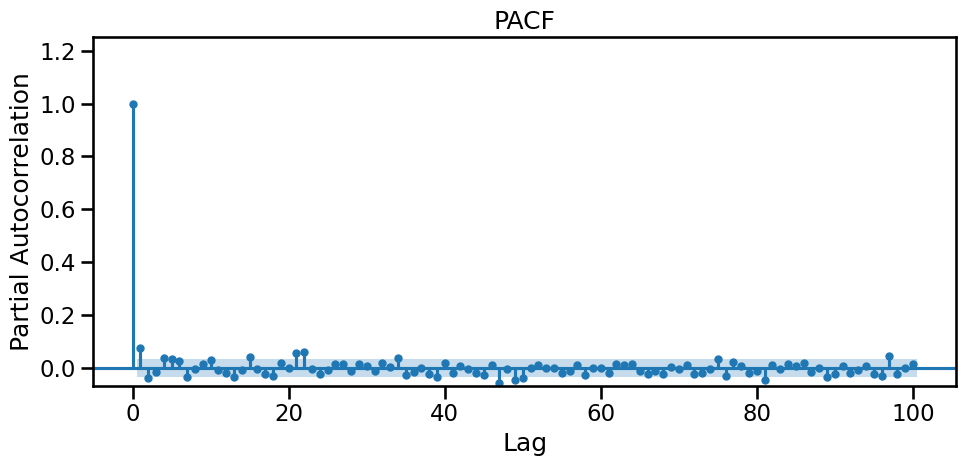

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(x=df["change"].dropna(), lags=100, ax=ax, alpha=0.05, auto_ylims=True)
ax.set_title("PACF")
ax.set_ylabel("Partial Autocorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

In [ ]:
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures, ExpandingWindowFeatures
from feature_engine.imputation import DropMissingData
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
df_ = df.copy()

In [ ]:
df_["lag_1"] = df_["change"].shift(1)

In [ ]:
df_ = df_.dropna()

In [ ]:
lag_transformer = LagFeatures(variables=["change"], periods=[2, 3, 4, 5, 20, 40, 50, 60, 80, 100])

In [ ]:
# window features
window_transformer = WindowFeatures( # tạo ra các biến mới dựa trên các biến đã có với window là kích thước của cửa sổ
    variables=["lag_1"],
    functions=["mean", "std", "kurt", "skew"],
    # tạo các window với lag = 1
    window=[5, 10, 20, 30, 60],
    periods=1,
)

In [ ]:
# expanding window features
expanding_transformer = ExpandingWindowFeatures( # expanding window là một cửa sổ có kích thước tăng dần từ 1 đến n với n là số lượng dữ liệu
    variables=["lag_1"],
    functions=["mean", "std", "kurt", "skew"],
    periods=1,
)

In [ ]:
imputer = DropMissingData() # loại bỏ các dòng có giá trị NaN

pipe = Pipeline(
    [
        ("lag", lag_transformer),
        ("imputer_1", imputer),
        ("window", window_transformer),
        ("imputer_2", imputer),
        ("expanding", expanding_transformer),
        ("imputer", imputer),
    ]
)

In [ ]:
df_ = pipe.fit_transform(df_)
df_

,price,change,lag_1,change_lag_2_x,change_lag_3_x,change_lag_4_x,change_lag_5_x,change_lag_20_x,change_lag_40_x,change_lag_50_x,...,lag_1_window_30_kurt_y,lag_1_window_30_skew_y,lag_1_window_60_mean_y,lag_1_window_60_std_y,lag_1_window_60_kurt_y,lag_1_window_60_skew_y,lag_1_expanding_mean_y,lag_1_expanding_std_y,lag_1_expanding_kurt_y,lag_1_expanding_skew_y
date,,,,,,,,,,,,,,,,,,,,,
2011-04-11,109.92,-2.544552,2.257480,1.350730,0.452280,-0.119849,0.491014,0.029656,-0.899743,3.190060,...,0.995978,-0.389765,0.329350,1.789795,0.380464,0.611973,0.543544,0.606281,1.753336,0.697213
2011-04-12,106.25,-3.338792,-2.544552,2.257480,1.350730,0.452280,-0.119849,-3.962842,-0.577762,-1.540297,...,0.756281,-0.419198,0.364421,1.806821,0.224574,0.555912,0.886331,0.929084,-0.172359,0.787514
2011-04-13,107.11,0.809412,-3.338792,-2.544552,2.257480,1.350730,0.452280,0.823215,0.794592,0.099152,...,0.432816,-0.460812,0.316783,1.845448,0.120415,0.533188,0.314517,1.628614,1.934913,-1.041539
2011-04-14,108.11,0.933620,0.809412,-3.338792,-2.544552,2.257480,1.350730,3.510921,1.611954,-0.352190,...,0.244656,-0.486541,0.269253,1.902347,0.043639,0.441226,-0.207384,2.029036,-0.740848,-0.672769
2011-04-15,109.66,1.433725,0.933620,0.809412,-3.338792,-2.544552,2.257480,-0.345100,-0.185271,-1.667771,...,0.469608,-0.522972,0.292228,1.900374,0.034338,0.406989,-0.080285,1.912611,-0.173050,-0.893363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,67.12,-4.346587,-1.571048,-1.709637,1.101199,-0.568261,0.627615,1.527698,-2.047988,6.277257,...,-0.437010,-0.273524,0.094581,2.229162,0.311039,0.169634,0.015580,2.400414,12.957139,0.621444
2023-06-13,69.42,3.426698,-4.346587,-1.571048,-1.709637,1.101199,-0.568261,-0.351568,0.037115,0.360607,...,-0.350707,-0.172256,0.107655,2.216815,0.362443,0.170415,0.015081,2.400202,12.958343,0.621946
2023-06-14,68.27,-1.656583,3.426698,-4.346587,-1.571048,-1.709637,1.101199,2.780130,-2.102399,-0.123900,...,-0.552235,-0.204111,0.012737,2.283699,0.253190,0.152029,0.013710,2.401070,12.935096,0.620904


In [ ]:
split_date = df_.index[-1] - pd.Timedelta("200D")
df_train = df_[df_.index <= split_date]
df_test = df_[df_.index > split_date]

In [ ]:
y_train = df_train["change"]

X_train = df_train.drop("change", axis=1)

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.05, random_state=0)
model.fit(X_train, y_train)

Lasso(alpha=0.05, random_state=0)

In [ ]:
feature_importances = pd.Series(index=X_train.columns, data=model.coef_)

In [ ]:
feature_importances.abs().sort_values(ascending=False)

lag_1_window_60_std_x     0.112610
lag_1                     0.051674
lag_1_window_30_std_x     0.050788
change_lag_50_x           0.033078
change_lag_2_x            0.031267
                            ...   
lag_1_window_60_skew_x    0.000000
lag_1_expanding_mean_x    0.000000
lag_1_expanding_std_x     0.000000
change_lag_20_y           0.000000
lag_1_expanding_skew_y    0.000000
Length: 69, dtype: float64

In [ ]:
---

SyntaxError: invalid syntax (1947214667.py, line 1)

---

### Dự đoán sử dụng 3 mùa vụ

In [ ]:
import warnings

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# phân tích chu kỳ cho dữ liệu
mstl = MSTL(df['price'], periods=(5, 20, 60)) # 5 là chu kỳ hàng tuần, 5*4 là chu kỳ hàng tháng, 5*4*3 là chu kỳ hàng quý
res = mstl.fit()

In [ ]:
# tạo forecast lưu index cho df_result từ ngày 2023-01-01 đến hết
forecast_time_start = "2023-03-26"
forecast_time_end = "2023-06-16"
forecast_time = pd.date_range(start=forecast_time_start, end=forecast_time_end, freq="B")
# tạo ra df_result với index là forecast
df_result = pd.DataFrame(index=forecast_time)

In [ ]:
df_trend = pd.DataFrame(res.trend)

In [ ]:
def create_df_train(df):
    df = df.set_index(df.index)
    df["lag_1"] = df.shift(1)
    df["lag_1_window_5_std"] = df["lag_1"].rolling(5).std()
    df["lag_1_window_60_mean"] = df["lag_1"].rolling(60).mean()
    df = df.dropna()
    return df

In [ ]:
def creat_df_forecast(df, forecast_time):
    df_forecast = pd.DataFrame(index=forecast_time)
    df_forecast = pd.concat([df.tail(60), df_forecast])

    # tạo các cột giá trị cho df_forecast
    df_forecast["lag_1"] = df_forecast["trend"].shift(1)
    df_forecast["lag_1_window_5_std"] = df_forecast["lag_1"].rolling(5).std()
    df_forecast["lag_1_window_60_mean"] = df_forecast["lag_1"].rolling(60).mean()
    
    df_forecast.reset_index(inplace=True)
    return df_forecast

In [ ]:
def creat_df_forecast(df, forecast_time):
    df_forecast = pd.DataFrame(index=forecast_time)
    df_forecast = pd.concat([df.tail(60), df_forecast])

    # tạo các cột giá trị cho df_forecast
    df_forecast["lag_1"] = df_forecast["trend"].shift(1)
    df_forecast["lag_1_window_5_std"] = df_forecast["lag_1"].rolling(5).std()
    df_forecast["lag_1_window_60_mean"] = df_forecast["lag_1"].rolling(60).mean()
    
    df_forecast.reset_index(inplace=True)
    return df_forecast

In [ ]:
# dự báo
def predict(df, model, forecast_time):
    warnings.filterwarnings("ignore")
    for i in range(60, len(df_forecast)):
        X = df_forecast.loc[i, [ 'lag_1', 'lag_1_window_5_std', 'lag_1_window_60_mean']].astype('float32')
        X = np.expand_dims(X, axis=0) # add extra dimension
        y_pred = model.predict(X)[0]

        df_forecast.loc[i, 'trend'] = float(y_pred)
        if i < len(df_forecast)-1:
            df_forecast.loc[i+1, 'lag_1'] = float(y_pred)
            df_forecast.loc[i+1, 'lag_1_window_5_std'] = df_forecast.loc[i-4:i, 'trend'].std()
            df_forecast.loc[i+1, 'lag_1_window_60_mean'] = df_forecast.loc[i-60+1:i, 'trend'].mean()
    df_forecast.set_index('index', inplace=True)
    return df_forecast[60:]

In [ ]:
# tạo vòng lặp for chạy từ -65 đến -1 với khoảng cách là 5
for i in range(-60, 0, 5):
    if i == 0:
        forecast_time = create_forecast_time(df_trend) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_trend) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_trend, forecast_time) # tạo dữ liệu dự báo
    else:
        forecast_time = create_forecast_time(df_trend[:i]) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_trend[:i]) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_trend[:i], forecast_time) # tạo dữ liệu dự báo
    # huấn luyện model
    model = LinearRegression()
    model.fit(df_train.drop(columns=['trend']), df_train['trend'])
    # dự báo
    df_forecast = predict(df_forecast, model, forecast_time)
    df_result.loc[df_forecast.index, 'trend'] = df_forecast['trend'].values

Text(0.5, 0, 'Time')

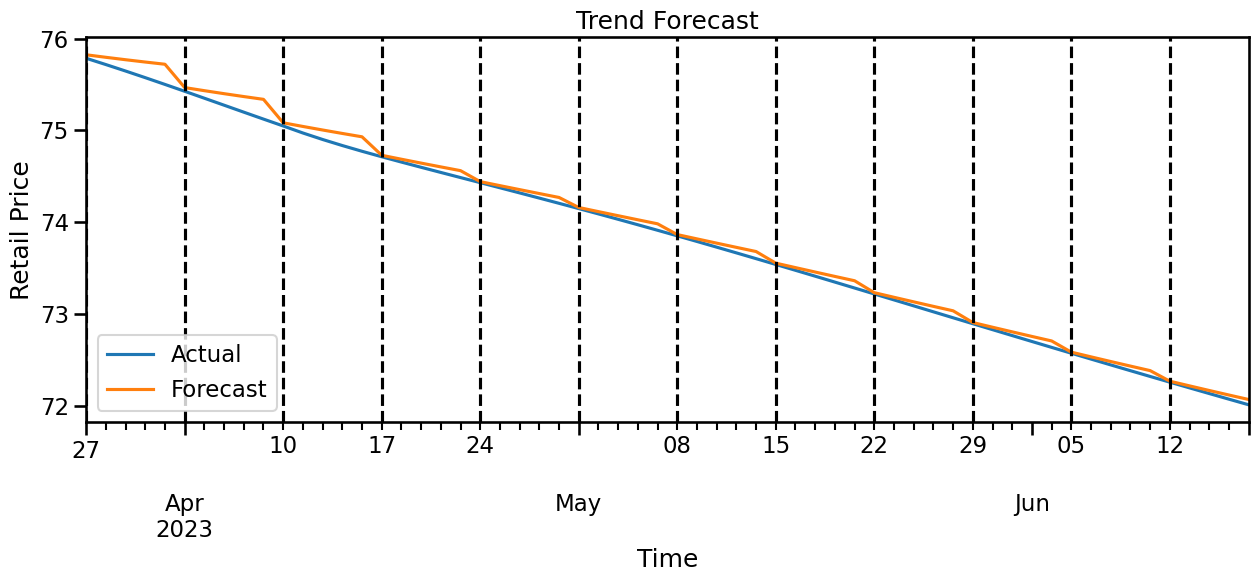

In [ ]:
# vẽ dữ liệu dự báo
# sửa fig size
plt.rcParams["figure.figsize"] = (15, 5)
ax = df_trend.loc['2023-03-26':, 'trend'].plot()
df_result['trend'].plot(ax=ax)
for i in range(0, 60, 5):
    ax.axvline(x=df_result.index[i], color='k', linestyle='--')
ax.legend(['Actual', 'Forecast'])
ax.set_title("Trend Forecast")
ax.set_ylabel("Retail Price")
ax.set_xlabel("Time")

---

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [ ]:
def create_forecast_time(df_train):
    # tạo forecast time start từ ngày cuối cùng của dữ liệu train + 1 ngày làm việc
    forecast_time_start = df_train.index[-1] + pd.Timedelta(days=1)
    forecast_time_end = forecast_time_start + pd.Timedelta(days=6)
    forecast_time = pd.date_range(start=forecast_time_start, end=forecast_time_end, freq="B")
    return forecast_time

In [ ]:
# tạo dataframe
df_ = pd.DataFrame(res.seasonal['seasonal_5'])
df_ = df_.set_index(df.index)
df_ = df_.rename(columns={'seasonal_5': "Price"})

In [ ]:
def create_df_train(df):
    df = df.set_index(df.index)
    df["lag_1"] = df.shift(1)
    df["lag_5"] = df["Price"].shift(5)
    df["lag_15"] = df["Price"].shift(15)
    df["lag_16"] = df["Price"].shift(16)
    df["lag_1_window_5_mean"] = df["lag_1"].rolling(5).mean()
    df = df.dropna()
    return df

In [ ]:
def creat_df_forecast(df, forecast_time):
    df_forecast = pd.DataFrame(index=forecast_time, columns=['Price'])
    df_forecast = pd.concat([df.tail(16), df_forecast])
    # tính giá trị cho các cột lag, window
    df_forecast['Price_lag_1'] = df_forecast['Price'].shift(1)
    df_forecast['Price_lag_5'] = df_forecast['Price'].shift(5)
    df_forecast['Price_lag_15'] = df_forecast['Price'].shift(15)
    df_forecast['Price_lag_16'] = df_forecast['Price'].shift(16)
    df_forecast['Price_mean'] = df_forecast['Price_lag_1'].rolling(5).mean()

    df_forecast.reset_index(inplace=True)
    return df_forecast

In [ ]:
# dự báo
def predict(df, model, forecast_time):
    warnings.filterwarnings("ignore")
    # thêm 1 ngày vào đầu df_forecast
    for i in range(16, len(df_forecast)):
        X = df_forecast.loc[i, ['Price_lag_1', 'Price_lag_5', 'Price_lag_15', 'Price_lag_16', 'Price_mean']].astype('float32')
        X = np.expand_dims(X, axis=0) # add extra dimension
        y_pred = model.predict(X)[0]

        df_forecast.loc[i, 'Price'] = float(y_pred)
        if i < len(df_forecast)-1:
            df_forecast.loc[i+1, 'Price_lag_1'] = float(y_pred)
            df_forecast.loc[i+1, 'Price_lag_5'] = df_forecast.loc[i-4, 'Price']
            df_forecast.loc[i+1, 'Price_lag_15'] = df_forecast.loc[i-14, 'Price']
            df_forecast.loc[i+1, 'Price_lag_16'] = df_forecast.loc[i-15, 'Price']
            df_forecast.loc[i+1, 'Price_mean'] = df_forecast.loc[i-4:i, 'Price'].mean()
    df_forecast.set_index('index', inplace=True)
    return df_forecast[16:]

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

In [ ]:
# tạo vòng lặp for chạy từ -65 đến -1 với khoảng cách là 5
for i in range(-60, 0, 5):
    if i == 0:
        forecast_time = create_forecast_time(df_) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_, forecast_time) # tạo dữ liệu dự báo
    else:
        forecast_time = create_forecast_time(df_[:i]) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_[:i]) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_[:i], forecast_time) # tạo dữ liệu dự báo
        # huấn luyện model
    X_train = df_train.drop(columns=['Price'])
    y_train = df_train['Price']

    param_grid = {
        'n_estimators': [100, 300],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3],
        'num_leaves': [10],
        'reg_lambda': [0.1, 0.5, 1],
        'reg_alpha': [0, 0.1, 0.5],
    }

    fixed_params = {
        'linear_tree': True,
        'linear_lambda' : 0.1,
    }

    lgbm = LGBMRegressor(**fixed_params)

    grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(best_params)
    model = LGBMRegressor(**best_params, **fixed_params)
    model.fit(X_train, y_train)

    model.fit(df_train.drop(columns=['Price']), df_train['Price'])
    # dự báo
    df_forecast = predict(df_forecast, model, forecast_time)
    df_result.loc[df_forecast.index, 'seasonal_5'] = df_forecast['Price'].values

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 1}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 1}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.5, 

Text(0.5, 0, 'Time')

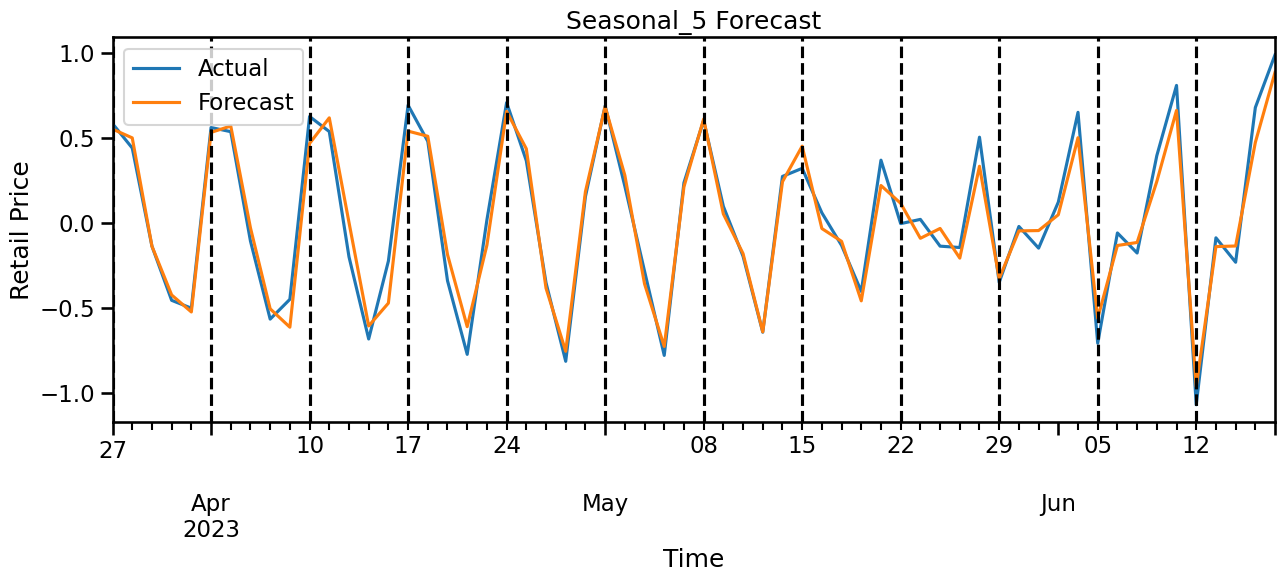

In [ ]:
# vẽ dữ liệu dự báo
# sửa fig size
plt.rcParams["figure.figsize"] = (15, 5)
ax = df_.loc['2023-03-26':, 'Price'].plot()
df_result['seasonal_5'].plot(ax=ax)
for i in range(0, len(df_result), 5):
    ax.axvline(x=df_result.index[i], color='k', linestyle='--')
ax.legend(['Actual', 'Forecast'])
ax.set_title("Seasonal_5 Forecast")
ax.set_ylabel("Retail Price")
ax.set_xlabel("Time")

In [ ]:
# tạo dataframe
df_ = pd.DataFrame(res.seasonal['seasonal_20'])
df_ = df_.set_index(df.index)
df_ = df_.rename(columns={'seasonal_20': "Price"})

In [ ]:
def create_df_train(df):
    df = df.set_index(df.index)
    df["lag_1"] = df.shift(1)
    df["lag_20"] = df["Price"].shift(20)
    df["lag_1_window_20_mean"] = df["lag_1"].rolling(20).mean()
    df = df.dropna()
    return df

In [ ]:
def creat_df_forecast(df, forecast_time):
    df_forecast = pd.DataFrame(index=forecast_time, columns=['Price'])
    df_forecast = pd.concat([df.tail(20), df_forecast])
    # tính giá trị cho các cột lag, window
    df_forecast['Price_lag_1'] = df_forecast['Price'].shift(1)
    df_forecast['Price_lag_20'] = df_forecast['Price'].shift(20)
    df_forecast['Price_mean'] = df_forecast['Price_lag_1'].rolling(20).mean()

    df_forecast.reset_index(inplace=True)
    return df_forecast

In [ ]:
# dự báo
def predict(df, model, forecast_time):
    warnings.filterwarnings("ignore")
    # thêm 1 ngày vào đầu df_forecast
    for i in range(20, len(df_forecast)):
        X = df_forecast.loc[i, ['Price_lag_1', 'Price_lag_20', 'Price_mean']].astype('float32')
        X = np.expand_dims(X, axis=0) # add extra dimension
        y_pred = model.predict(X)[0]

        df_forecast.loc[i, 'Price'] = float(y_pred)
        if i < len(df_forecast)-1:
            df_forecast.loc[i+1, 'Price_lag_1'] = float(y_pred)
            df_forecast.loc[i+1, 'Price_lag_20'] = df_forecast.loc[i-19, 'Price']
            df_forecast.loc[i+1, 'Price_mean'] = df_forecast.loc[i-20+1:i, 'Price'].mean()
    df_forecast.set_index('index', inplace=True)
    return df_forecast[20:]

In [ ]:
# tạo vòng lặp for chạy từ -65 đến -1 với khoảng cách là 5
for i in range(-60, 0, 5):
    if i == 0:
        forecast_time = create_forecast_time(df_) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_, forecast_time) # tạo dữ liệu dự báo
    else:
        forecast_time = create_forecast_time(df_[:i]) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_[:i]) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_[:i], forecast_time) # tạo dữ liệu dự báo
        # huấn luyện model
    X_train = df_train.drop(columns=['Price'])
    y_train = df_train['Price']

    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3],
        'num_leaves': [10],
        'reg_lambda': [0.1, 0.5, 1],
        'reg_alpha': [0, 0.1, 0.5],
    }

    fixed_params = {
        'linear_tree': True,
        'linear_lambda' : 0.1,
    }

    lgbm = LGBMRegressor(**fixed_params)

    grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(best_params)
    model = LGBMRegressor(**best_params, **fixed_params)
    model.fit(X_train, y_train)

    model.fit(df_train.drop(columns=['Price']), df_train['Price'])
    # dự báo
    df_forecast = predict(df_forecast, model, forecast_time)
    df_result.loc[df_forecast.index, 'seasonal_20'] = df_forecast['Price'].values

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 0.1}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 0.5}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_

Text(0.5, 0, 'Time')

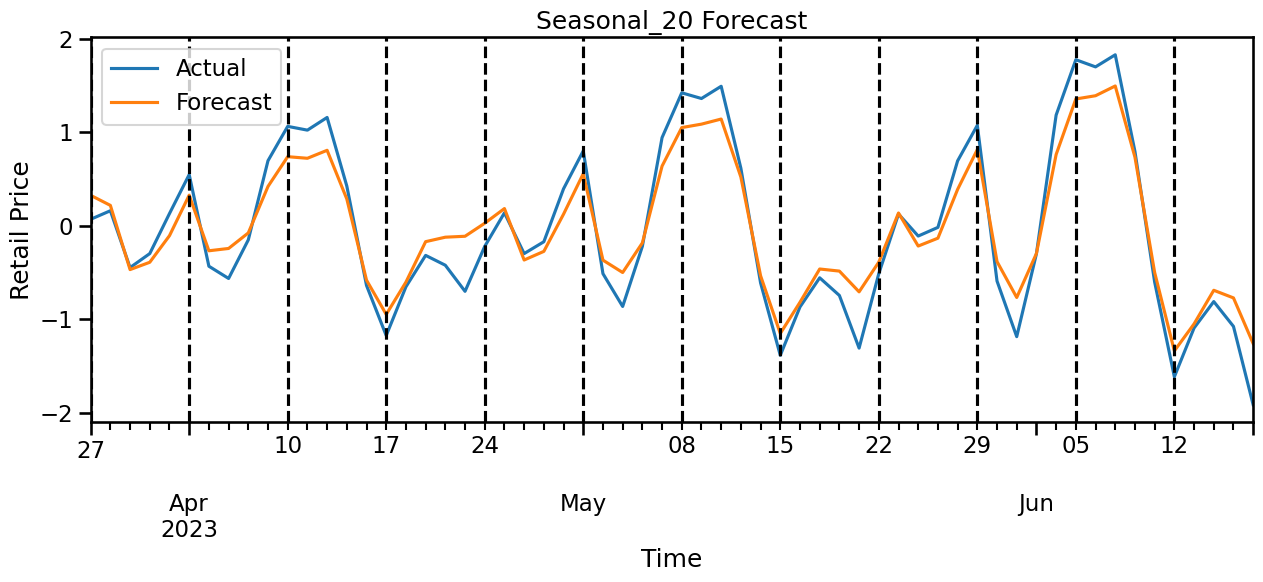

In [ ]:
# vẽ dữ liệu dự báo
# sửa fig size
plt.rcParams["figure.figsize"] = (15, 5)
ax = df_.loc['2023-03-26':, 'Price'].plot()
df_result['seasonal_20'].plot(ax=ax)
for i in range(0, len(df_result), 5):
    ax.axvline(x=df_result.index[i], color='k', linestyle='--')
ax.legend(['Actual', 'Forecast'])
ax.set_title("Seasonal_20 Forecast")
ax.set_ylabel("Retail Price")
ax.set_xlabel("Time")

In [ ]:
df_ = pd.DataFrame(res.seasonal['seasonal_60'])
df_ = df_.set_index(df.index)
df_ = df_.rename(columns={'seasonal_60': "Price"})
df_

,Price
date,
2010-01-04,2.468335
2010-01-05,2.154045
2010-01-06,1.688232
2010-01-07,1.407908
2010-01-08,2.114066
...,...
2023-06-12,-2.922489
2023-06-13,-2.802580
2023-06-14,-2.483945


In [ ]:
def create_df_train(df):
    df = df.set_index(df.index)
    df["lag_20"] = df.shift(20)
    df["lag_40"] = df["Price"].shift(40)
    df["lag_60"] = df["Price"].shift(60)
    df = df.dropna()
    return df

In [ ]:
def creat_df_forecast(df, forecast_time):
    df_forecast = pd.DataFrame(index=forecast_time, columns=['Price'])
    df_forecast = pd.concat([df.tail(60), df_forecast])
    # tính giá trị cho các cột lag, window
    df_forecast['Price_lag_20'] = df_forecast['Price'].shift(20)
    df_forecast['Price_lag_40'] = df_forecast['Price'].shift(40)
    df_forecast['Price_lag_60'] = df_forecast['Price'].shift(60)

    df_forecast.reset_index(inplace=True)
    return df_forecast

In [ ]:
# dự báo
def predict(df, model, forecast_time):
    warnings.filterwarnings("ignore")
    for i in range(60, len(df_forecast)):
        X = df_forecast.loc[i, [ 'Price_lag_20', 'Price_lag_40', 'Price_lag_60']].astype('float32')
        X = np.expand_dims(X, axis=0) # add extra dimension
        y_pred = model.predict(X)[0]

        df_forecast.loc[i, 'Price'] = float(y_pred)
        if i < len(df_forecast)-1:
            df_forecast.loc[i+1, 'Price_lag_20'] = df_forecast.loc[i-19, 'Price']
            df_forecast.loc[i+1, 'Price_lag_40'] = df_forecast.loc[i-39, 'Price']
            df_forecast.loc[i+1, 'Price_lag_60'] = df_forecast.loc[i-59, 'Price']
    df_forecast.set_index('index', inplace=True)
    return df_forecast[60:]

In [ ]:
# tạo vòng lặp for chạy từ -65 đến -1 với khoảng cách là 5
for i in range(-60, 0, 5):
    if i == 0:
        forecast_time = create_forecast_time(df_) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_, forecast_time) # tạo dữ liệu dự báo
    else:
        forecast_time = create_forecast_time(df_[:i]) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_[:i]) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_[:i], forecast_time) # tạo dữ liệu dự báo
        # huấn luyện model
    X_train = df_train.drop(columns=['Price'])
    y_train = df_train['Price']

    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.05],
        'max_depth': [3],
        'num_leaves': [10],
        'reg_lambda': [0.1, 0.5, 1],
        'reg_alpha': [0, 0.1, 0.5],
    }

    fixed_params = {
        'boosting': 'gbdt',
        'linear_tree': True,
        'linear_lambda' : 0.1,
    }

    lgbm = LGBMRegressor(**fixed_params)

    grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(best_params)
    model = LGBMRegressor(**best_params, **fixed_params)
    model.fit(X_train, y_train)
    # dự báo
    df_forecast = predict(df_forecast, model, forecast_time)
    df_result.loc[df_forecast.index, 'seasonal_60'] = df_forecast['Price'].values

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 0.1}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
{'

Text(0.5, 0, 'Time')

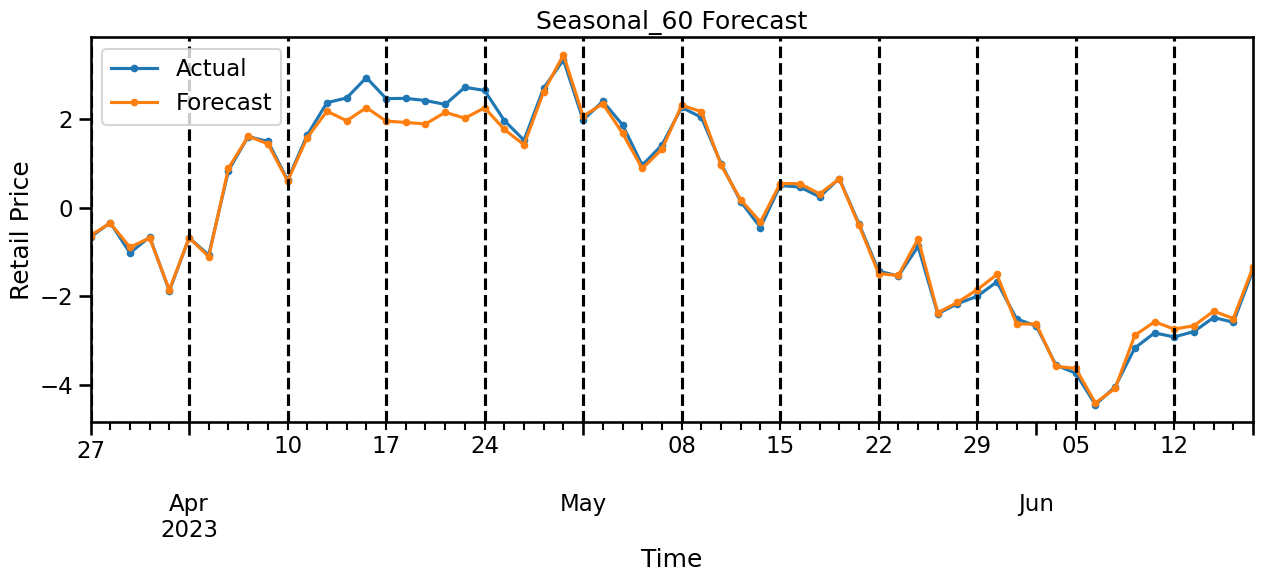

In [ ]:
# vẽ dữ liệu dự báo
# sửa fig size
plt.rcParams["figure.figsize"] = (15, 5)
ax = df_.loc['2023-03-26':, 'Price'].plot(style='.-')
df_result['seasonal_60'].plot(ax=ax, style='.-')
for i in range(0, len(df_result), 5):
    ax.axvline(x=df_result.index[i], color='k', linestyle='--')
ax.legend(['Actual', 'Forecast'])
ax.set_title("Seasonal_60 Forecast")
ax.set_ylabel("Retail Price")
ax.set_xlabel("Time")

--

In [ ]:
df_ = pd.DataFrame(res.resid)
df_ = df_.set_index(df.index)
df_

,resid
date,
2010-01-04,4.632364
2010-01-05,4.474183
2010-01-06,4.965215
2010-01-07,5.046257
2010-01-08,4.352025
...,...
2023-06-12,0.470153
2023-06-13,1.208995
2023-06-14,-0.337696


In [ ]:
def create_df_train(df):
    df = df.set_index(df.index)
    df["lag_1"] = df.shift(1)
    df["lag_20"] = df["resid"].shift(20)
    df["lag_60"] = df["resid"].shift(60)
    df["lag_61"] = df["resid"].shift(61)
    df["lag_1_window_5_mean"] = df["lag_1"].rolling(5).mean()
    df = df.dropna()
    return df

In [ ]:
def creat_df_forecast(df, forecast_time):
    df_forecast = pd.DataFrame(index=forecast_time, columns=['resid'])
    df_forecast = pd.concat([df.tail(61), df_forecast])
    # tính giá trị cho các cột lag, window
    df_forecast['Price_lag_1'] = df_forecast['resid'].shift(1)
    df_forecast['Price_lag_20'] = df_forecast['resid'].shift(20)
    df_forecast['Price_lag_60'] = df_forecast['resid'].shift(60)
    df_forecast['Price_lag_61'] = df_forecast['resid'].shift(61)
    df_forecast['Price_lag_1_window_5_mean'] = df_forecast['Price_lag_1'].rolling(5).mean()

    df_forecast.reset_index(inplace=True)
    return df_forecast

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
result = []
def predict(df_, X_train, y_train):
    model = SARIMAX(endog=y_train, order=(1, 0, 1), seasonal_order=(4, 0, 1, 20))
    results = model.fit()
    start = len(X_train)
    end = len(X_train) + 4
    predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMAX Predictions')
    result.append(predictions)
    return result

# dự đoán 5 ngày 1
# tạo vòng lặp for chạy từ -65 đến -1 với khoảng cách là 5
for i in range(-60, 0, 5):
    if i == 0:
        forecast_time = create_forecast_time(df_) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_, forecast_time) # tạo dữ liệu dự báo
    else:
        forecast_time = create_forecast_time(df_[:i]) # tạo index cho dữ liệu dự báo
        df_train = create_df_train(df_[:i]) # tạo dữ liệu train
        df_forecast = creat_df_forecast(df_[:i], forecast_time) # tạo dữ liệu dự báo
        # huấn luyện model
    X_train = df_train.drop(columns=['resid'])
    y_train = df_train['resid']

    predict(df_, X_train, y_train)

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred fr

In [ ]:
predic = pd.concat(result)
predic = predic.to_frame()
predic = predic.rename(columns={0: 'Price'})

predic['date'] = predic.index
predic = predic.set_index('date')
predic = predic.rename(columns={'SARIMAX Predictions': 'Price'})

,Price
date,
2023-03-27,-4.295455
2023-03-28,-3.439912
2023-03-29,-1.666763
2023-03-30,-1.817084
2023-03-31,-1.134501
2023-04-03,2.475622
2023-04-04,1.746100
2023-04-05,0.291848
2023-04-06,0.857035


In [ ]:
# đưa predict vào cột resid trong df_result với index tương ứng
df_result['resid'] = predic['Price']

Text(0.5, 0, 'Time')

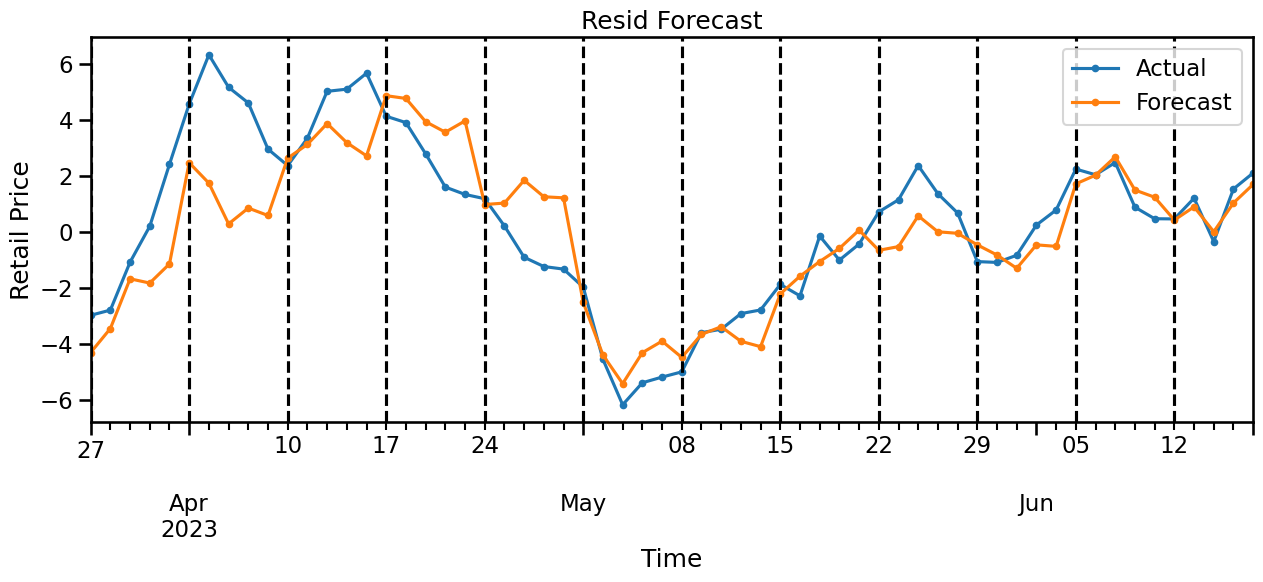

In [ ]:
plt.rcParams["figure.figsize"] = (15, 5)
ax = df_.loc['2023-03-26':, 'resid'].plot(style='.-')
df_result['resid'].plot(ax=ax, style='.-')
for i in range(0, len(df_result), 5):
    ax.axvline(x=df_result.index[i], color='k', linestyle='--')
ax.legend(['Actual', 'Forecast'])
ax.set_title("Resid Forecast")
ax.set_ylabel("Retail Price")
ax.set_xlabel("Time")

In [ ]:
df_result

,resid,trend,seasonal_5,seasonal_20,seasonal_60
2023-03-27,-4.295455,75.824423,0.553438,0.326156,-0.629566
2023-03-28,-3.439912,75.796963,0.501874,0.218206,-0.348384
2023-03-29,-1.666763,75.770547,-0.134803,-0.469115,-0.895731
2023-03-30,-1.817084,75.745352,-0.421308,-0.390758,-0.682397
2023-03-31,-1.134501,75.721209,-0.521209,-0.106026,-1.858653
2023-04-03,2.475622,75.466959,0.534066,0.327683,-0.681406
2023-04-04,1.746100,75.433194,0.571524,-0.267775,-1.107341
2023-04-05,0.291848,75.400512,-0.027235,-0.242968,0.893061
2023-04-06,0.857035,75.369086,-0.502586,-0.076513,1.613690
2023-04-07,0.592104,75.338702,-0.610738,0.420977,1.446224


Text(0.5, 0, 'Time')

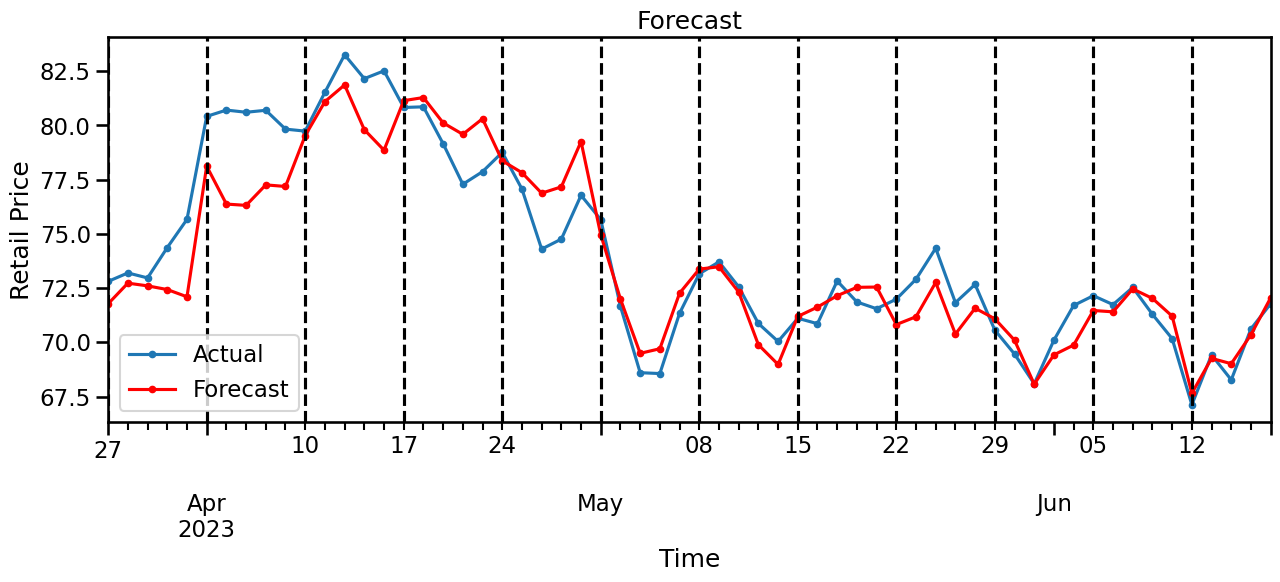

In [ ]:
# tính lại cột Price bằng tổng các cột trend, seasonal_20, seasonal_60, resid
df_result['Price'] = df_result['trend'] + df_result['seasonal_5'] +  df_result['seasonal_20'] + df_result['seasonal_60'] + df_result['resid']

# vẽ đồ thị 
plt.rcParams["figure.figsize"] = (15, 5)
ax = df.loc["2023-03-26":, "price"].plot(marker='.')
pd.DataFrame(df_result["Price"], columns=["Price"]).plot(ax=ax, color="red", marker='.')
# vẽ các đường dọc ngăn cách 5 ngày 1 lần
for i in range(0, len(df_result), 5):
    ax.axvline(x=df_result.index[i], color='k', linestyle='--')
# legend
ax.legend(['Actual', 'Forecast'])
ax.set_title("Forecast")
ax.set_ylabel("Retail Price")
ax.set_xlabel("Time")